In [1]:
import sympy as sp
from   sympy import erf, exp, ln, oo, sqrt, Eq, Integral, Max, Symbol
from   sympy.plotting import plot, plot_parametric
from   sympy.stats import density, Normal

f"SymPy v{sp.__version__}"

'SymPy v1.11.1'

In [2]:
class BlackScholes():
    def __init__(self, S=100, K=100, σ=0.5, T=1, t=0, r=0, p=1):

        # Initial state
        self.S, self.K, self.σ, self.T, self.t, self.r, self.p = S, K, σ, T, t, r, p
        
        S = Symbol('S') # stock price at t (spot)
        F = Symbol('F') # stock price at T (final)
        K = Symbol('K') # strike
        σ = Symbol('σ') # volatility
        T = Symbol('T') # time to maturity (in years)
        t = Symbol('t') # time from today (0 <= t <= T)
        r = Symbol('r') # interest rate
        p = Symbol('p') # parity; +/-1 for CALL/PUT
        
        # Helpers
        norm_cdf = lambda x: 0.5 * (1 + erf(x * 2**-0.5))
        d1 = 1 / (σ * sqrt(T - t)) * (ln(S / K) + (r + 0.5 * σ * σ) * (T - t))
        d2 = d1 - σ * sqrt(T - t)

        # Option Prices (aka Black-Scholes formula)
        f_price = p * S * norm_cdf(p * d1) - p * K * exp(-r * (T - t)) * norm_cdf(p * d2)
        
        # Stock Price Distribution at Maturity (aka Risk-Neutral Measure)
        f_pdf  = density(S * exp((r - 0.5*σ*σ) * (T - t) + σ * sqrt(T - t) * Normal('W', 0, 1)))(F)
        
        
        # ==== PUBLIC METHODS =======================================================

        self.pdf   = self._evalf( f_pdf )
        
        # Greeks: 1st order
        self.price = self._evalf( f_price )
        self.delta = self._evalf( f_price.diff(S) )
        self.vega  = self._evalf( f_price.diff(σ) )
        self.theta = self._evalf( f_price.diff(t) )
        self.rho   = self._evalf( f_price.diff(r) )
        
        # Greeks: 2nd order
        self.gamma = self._evalf( f_price.diff(S).diff(S) )
        self.vomma = self._evalf( f_price.diff(σ).diff(σ) )
        # ...

    def _evalf(self, f):
        def wrap(**kwargs):
            subs = {
                'S': self.S,
                'K': self.K,
                'σ': self.σ,
                'T': self.T,
                't': self.t,
                'r': self.r,
                'p': self.p,
                **kwargs
            }
            return f.subs(subs).evalf(subs=subs)
        return wrap


# plot helper
def plot(*args):
    x_range = args[-1]
    p0 = None
    for i in range(0, len(args)-1):
        pi = sp.plotting.plot(args[i], x_range, label=f'#{i}', line_color=f'C{i}', legend=True, show=False)
        if p0 is None:
            p0 = pi
        else:
            p0.extend(pi)
    p0.show()
    return p0


# General-Purpose Symbol:
x = Symbol('x') # anything
F = Symbol('F') # forward price

## Example: AMD Option

In [3]:
AMD = BlackScholes(K=90, T=45./365, S=82, σ=0.338, r=0, p=1)

### Stock Price Distribution

In [4]:
AMD.pdf()

3.36150329182974*exp(-35.49906827103*(log(F/82) + 0.00704243835616438)**2)/Abs(F)

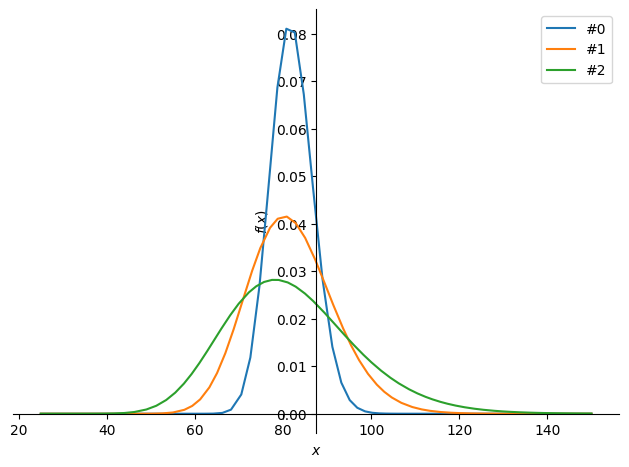

In [5]:
plot(
    AMD.pdf(F=x, σ=AMD.σ*0.5),    # 0 - x0.5 vol
    AMD.pdf(F=x),                 # 1 - x1.0 vol
    AMD.pdf(F=x, σ=AMD.σ*1.5),    # 2 - x1.5 vol
    
    (x, 25, 150))                 # x - Stock Price at Maturity

#### Is total probability normalized to 1.0 ?

In [6]:
Integral(AMD.pdf(F=x), (x,0,oo)).evalf()

1.00000000000000

#### Probability of stock price above spot

In [7]:
print(f'Spot Price = {AMD.S}')
Integral(AMD.pdf(F=x), (x, AMD.S, oo)).evalf()

Spot Price = 82


0.476340706023973

#### Probability of stock price above strike

In [8]:
print(f'Strike = {AMD.K}')
Integral(AMD.pdf(F=x), (x, AMD.K, oo)).evalf()

Strike = 90


0.199411989944848

### Call/Put Prices

In [9]:
print(f'Call Price = {AMD.price(p=+1)}')
print(f'Put  Price = {AMD.price(p=-1)}')

Call Price = 1.25835519602241
Put  Price = 9.25835519602241


### Call/Put Prices: Direct Integration

In [10]:
call = Integral(Max(F - AMD.K, 0) * AMD.pdf(), (F, AMD.K, oo)).evalf(4)
put  = Integral(Max(AMD.K - F, 0) * AMD.pdf(), (F, 0, AMD.K)).evalf(4)

print('Should be as Above!')
print(f'Call Price = {call}')
print(f'Put  Price = {put}')

Should be as Above!
Call Price = 1.258
Put  Price = 9.258


### Premium Decay

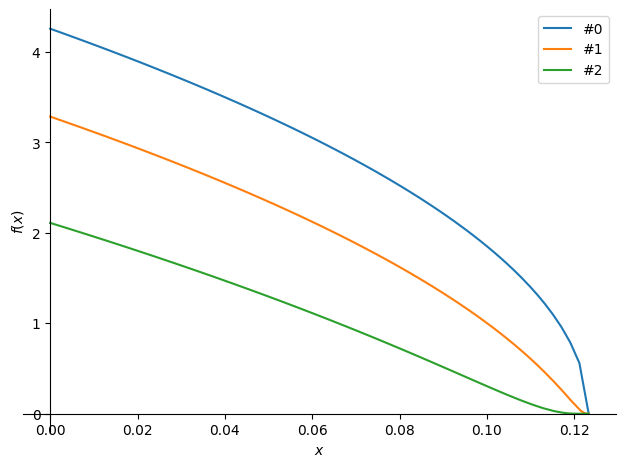

In [11]:
plot(
    AMD.price(t=x, S=AMD.K),    # 0 -     at-the money
    AMD.price(t=x, S=AMD.K-2),  # 1 - $2 out-the-money
    AMD.price(t=x, S=AMD.K-5),  # 2 - $5 out-the-money
    
    (x, 0.0, AMD.T))            # x - Days from Today

## Greeks

### Delta (vs Spot Price at various times)

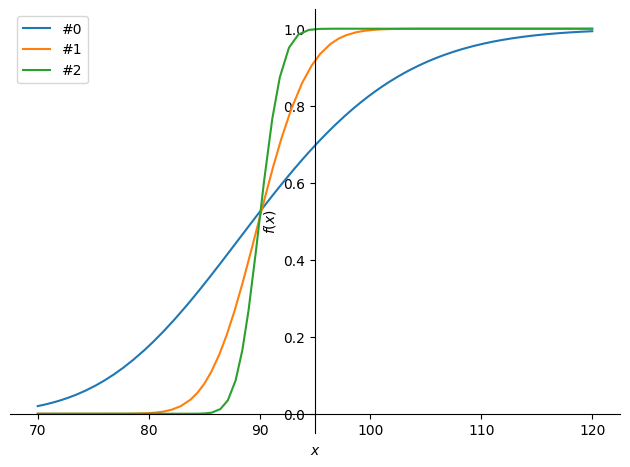

In [12]:
plot(
    AMD.delta(S=x),             # 0 - today
    AMD.delta(S=x, t=40/365.),  # 1 - 40 days from today (5 days to expiry)
    AMD.delta(S=x, t=44/365.),  # 2 - 44 days from today (1 day  to expiry)
    
    (x, 70, 120))               # x - Spot Price

### Delta (vs Time from Today at various Spot Price)

This tells how much stocks to keep for delta hedging (at maturity when x → T: for ITM → 1, for OTM → 0).

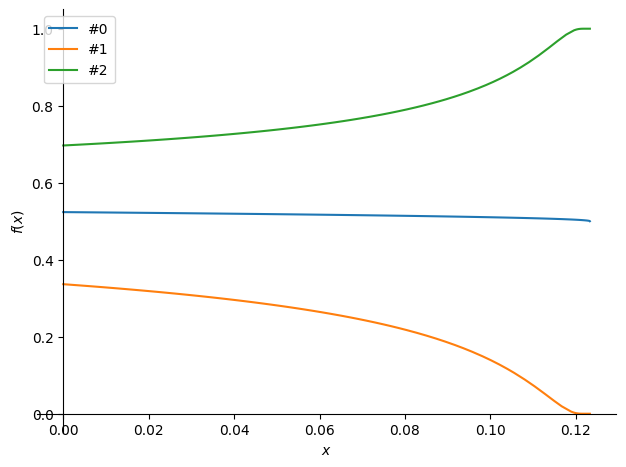

In [13]:
plot(
    AMD.delta(t=x, S=AMD.K),     # 0 -     at-the money
    AMD.delta(t=x, S=AMD.K-5),   # 1 - $5 out-the-money 
    AMD.delta(t=x, S=AMD.K+5),   # 2 - $5  in-the-money
    
    (x, 0.0, AMD.T))             # x - Days from Today

### Theta (Premium Decay Rate)

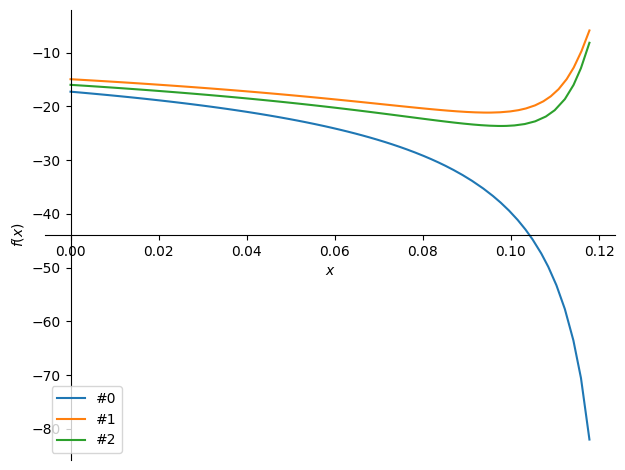

In [14]:
plot(
    AMD.theta(t=x, S=AMD.K),     # 0 -     at-the money
    AMD.theta(t=x, S=AMD.K-5),   # 1 - $5 out-the-money 
    AMD.theta(t=x, S=AMD.K+5),   # 2 - $5  in-the-money
    
    (x, 0.0, AMD.T-2/365.))      # x - Days from Today

### Gamma

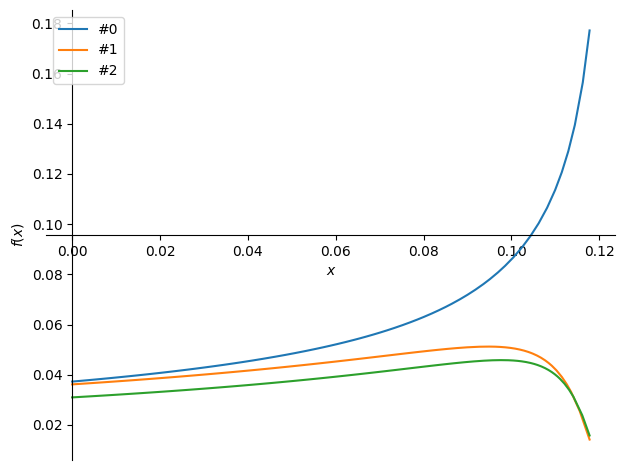

In [15]:
plot(
    AMD.gamma(t=x, S=AMD.K),     # 0 -     at-the money
    AMD.gamma(t=x, S=AMD.K-5),   # 1 - $5 out-the-money 
    AMD.gamma(t=x, S=AMD.K+5),   # 2 - $5  in-the-money
    
    (x, 0.0, AMD.T-2/365.))      # x - Days from Today

### Vomma

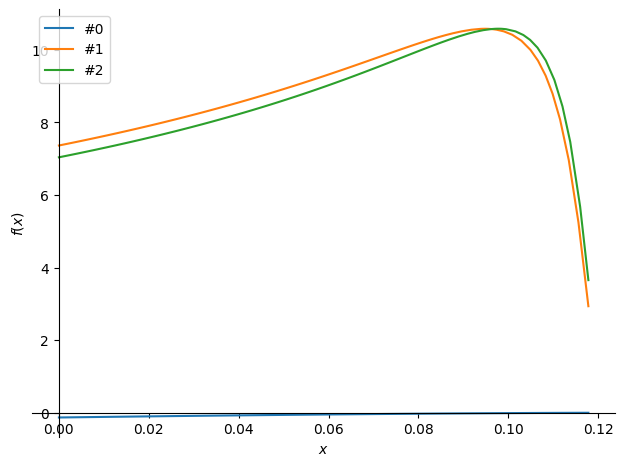

In [16]:
plot(
    AMD.vomma(t=x, S=AMD.K),     # 0 -     at-the money
    AMD.vomma(t=x, S=AMD.K-5),   # 1 - $5 out-the-money 
    AMD.vomma(t=x, S=AMD.K+5),   # 2 - $5  in-the-money
    
    (x, 0.0, AMD.T-2/365.))      # x - Days from Today